In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
# Define file paths
CELL_TYPES_FILE = "data/consolidated_cell_types.csv.gz"
CONNECTIONS_FILE = "data/connections_princeton_no_threshold.csv.gz"

In [3]:
# Load cell types
cell_types = pd.read_csv(CELL_TYPES_FILE)

print("Cell types shape:", cell_types.shape)
cell_types.head()

Cell types shape: (137677, 3)


,root_id,primary_type,additional_type(s)
0,720575940596125868,T5c,NaN
1,720575940597856265,Tm16,NaN
2,720575940597944841,Tm7,CB3851
3,720575940598267657,TmY15,NaN
4,720575940599333574,Tm1,NaN


In [4]:
# Load connections (note: large file!)
# Using low_memory=False to avoid dtype warnings
connections = pd.read_csv(CONNECTIONS_FILE, low_memory=False)

print("Connections shape:", connections.shape)
connections.head()

Connections shape: (22285323, 5)


,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940625363947,720575940623224444,ME_L,12,GABA
1,720575940613354467,720575940616690107,ME_L,1,ACH
2,720575940630432382,720575940618518557,ME_L,67,ACH
3,720575940627314521,720575940626337738,ME_L,10,GABA
4,720575940616775218,720575940632128018,ME_L,1,ACH


In [5]:
# Helpers
def partner_weights_bidirectional(
    connections: pd.DataFrame, target_id: int
) -> pd.DataFrame:
    """
    For a target neuron, return partner-wise inbound and outbound synapse weights.
    Aggregates across neuropils (sums syn_count).

    Returns columns:
      partner_id, in_w (partner→target), out_w (target→partner)
    """
    # inputs to target (pre → target)
    inp = (
        connections.loc[
            connections["post_root_id"] == target_id, ["pre_root_id", "syn_count"]
        ]
        .groupby("pre_root_id", as_index=False)["syn_count"]
        .sum()
        .rename(columns={"pre_root_id": "partner_id", "syn_count": "in_w"})
    )

    # outputs from target (target → post)
    out = (
        connections.loc[
            connections["pre_root_id"] == target_id, ["post_root_id", "syn_count"]
        ]
        .groupby("post_root_id", as_index=False)["syn_count"]
        .sum()
        .rename(columns={"post_root_id": "partner_id", "syn_count": "out_w"})
    )

    # outer-join so partners with only in_w or only out_w are included (zeros allowed)
    df = pd.merge(inp, out, on="partner_id", how="outer").fillna(
        {"in_w": 0, "out_w": 0}
    )

    return df


def attach_partner_types(df: pd.DataFrame, cell_types: pd.DataFrame) -> pd.DataFrame:
    """
    Add partner primary_type (if available)
    """
    return (
        df.merge(
            cell_types[["root_id", "primary_type"]],
            left_on="partner_id",
            right_on="root_id",
            how="left",
        )
        .drop(columns=["root_id"])
        .rename(columns={"primary_type": "partner_type"})
    )

In [6]:
# Wedge math and plotting
import itertools
from matplotlib.cm import tab10
import os


def reciprocity_mask(
    df: pd.DataFrame, wmin: int = 50, angle_deg: float = 20.0
) -> np.ndarray:
    """
    Return boolean mask for points inside a 'wedge' centered on the diagonal (45°)
      - in_w >= wmin and out_w > wmin
      - |atan2(in_w, out_w| <= angle_deg
    """
    x = df["out_w"].to_numpy(dtype=float)
    y = df["in_w"].to_numpy(dtype=float)

    # avoid division issues: if both zero they'll be excluded by wmin anyway
    ang = np.degrees(np.arctan2(y, x))  # 0..90 for positive quadrant
    return (x >= wmin) & (y >= wmin) & (np.abs(ang - 45.0) <= angle_deg)


def plot_reciprocity(
    df: pd.DataFrame,
    target_label: str,
    target_id: int = None,
    wmin: int = 50,
    angle_deg: float = 20.0,
    annotate_top: int = 12,
    label_col: str = "partner_type",
    save: bool = True,
):
    """
    Scatter of in_w vs out_w with a shaded wedge around the diagonal.
    - wmin: minimum weight on both axes to be considered 'strong'
    - angle_deg: half-angle of the wedge around 45°
    - annotate_top: annotate top-N most reciprocal (by geometric mean) inside the wedge
    - save: whether to save the figure under 'figures/' directory
    """
    x = df["out_w"].to_numpy()
    y = df["in_w"].to_numpy()

    fig, ax = plt.subplots(figsize=(8, 6))

    # base scatter (light points)
    ax.scatter(x, y, s=8, alpha=0.25)

    # diagonal
    lim = max(x.max(), y.max()) * 1.05 if len(df) else 1
    ax.plot([0, lim], [0, lim], ls="--")

    # wedge polygon (in data coords)
    a1 = np.radians(45 - angle_deg)
    a2 = np.radians(45 + angle_deg)
    r = lim * 1.5
    p0 = (wmin, wmin)
    p1 = (wmin + r * np.cos(a1), wmin + r * np.sin(a1))
    p2 = (wmin + r * np.cos(a2), wmin + r * np.sin(a2))
    wedge = Polygon(
        [p0, p1, p2], closed=True, facecolor="orange", alpha=0.15, edgecolor="none"
    )
    ax.add_patch(wedge)

    # emphasize points inside wedge
    inside = reciprocity_mask(df, wmin=wmin, angle_deg=angle_deg)
    ax.scatter(x[inside], y[inside], s=16, alpha=0.8)

    # annotate top-N reciprocal partners
    if annotate_top and inside.any():
        gm = np.sqrt(x * y)
        idx = np.argsort(gm * inside)[-annotate_top:]
        colors = itertools.cycle(tab10.colors)

        for i, color in zip(idx, colors):
            label = str(df.iloc[i][label_col])
            ax.scatter(x[i], y[i], s=35, color=color, label=label, zorder=3)
            ax.annotate(
                label,
                (x[i], y[i]),
                xytext=(6, 6),
                textcoords="offset points",
                fontsize=8,
                color=color,
            )

        ax.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1))

    # labels and title
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_xlabel(f"synaptic weight from {target_label}")
    ax.set_ylabel(f"synaptic weight to {target_label}")
    ax.set_title(
        f"Reciprocity around {target_label}"#\n(wedge: ≥{wmin} & ±{angle_deg}° of diagonal)"
    )
    plt.tight_layout()

    # --- Save figure ---
    if save:
        os.makedirs("figures", exist_ok=True)
        safe_label = target_label.replace(" ", "_")
        if target_id is not None:
            filename = f"figures/reciprocity_{safe_label}_{target_id}.png"
        else:
            filename = f"figures/reciprocity_{safe_label}.png"
        plt.savefig(filename, dpi=150, bbox_inches="tight")
        print(f"Figure saved to: {filename}")

    plt.show()

In [7]:
# Define neurons of interest
neurons_of_interest = {
    "OviEN": {
        720575940612490958: "oviEN Left",
        720575940635515744: "oviEN Right",
    },
    "oviIN": {
        720575940628360506: "oviIN Left",
        720575940625741287: "oviIN Right",
    },
    "PAL02": {
        720575940628717585: "PAL02 Left",
        720575940620716897: "PAL02 Right",
    },
    "PAL04": {
        720575940632369439: "PAL04 Left",
        720575940636990064: "PAL04 Right",
    },
    "Earmuff": {
        720575940635642725: "Earmuff Left 1",
        720575940611411057: "Earmuff Right 1",
        720575940629861163: "Earmuff Left 2",
        720575940629013199: "Earmuff Right 2",
    },
    "Tophat": {
        720575940660281217: "Tophat Left 1",
        720575940638865011: "Tophat Right 1",
        720575940622541005: "Tophat Left 2",
        720575940620441024: "Tophat Right 2",
    },
    "SMP": {720575940633705636: "SMP544"},
}


=== Processing group: OviEN ===
  → Analyzing oviEN Left (720575940612490958)
Figure saved to: figures/reciprocity_oviEN_Left_720575940612490958.png


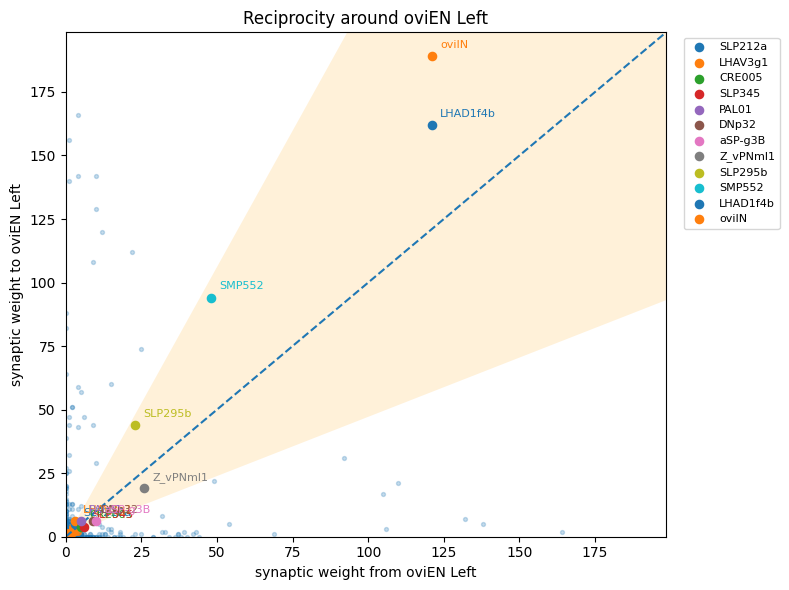

  → Analyzing oviEN Right (720575940635515744)
Figure saved to: figures/reciprocity_oviEN_Right_720575940635515744.png


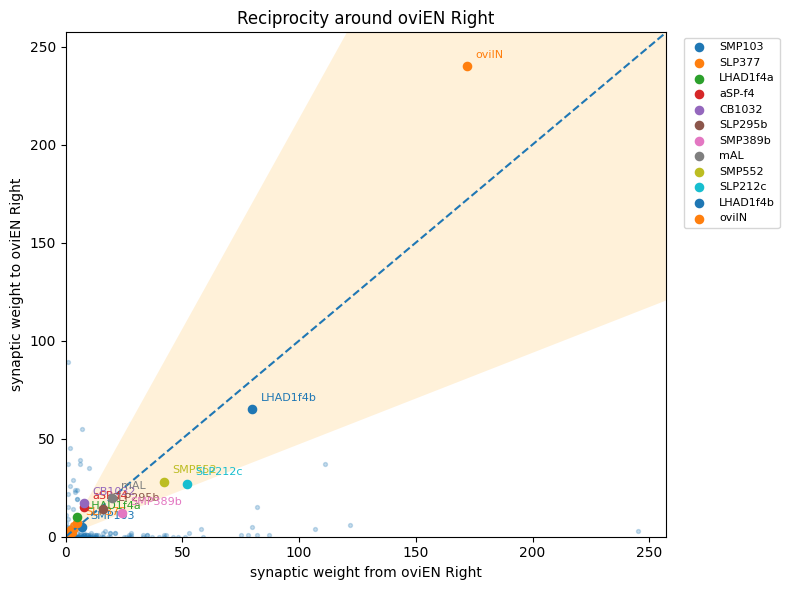


=== Processing group: oviIN ===
  → Analyzing oviIN Left (720575940628360506)
Figure saved to: figures/reciprocity_oviIN_Left_720575940628360506.png


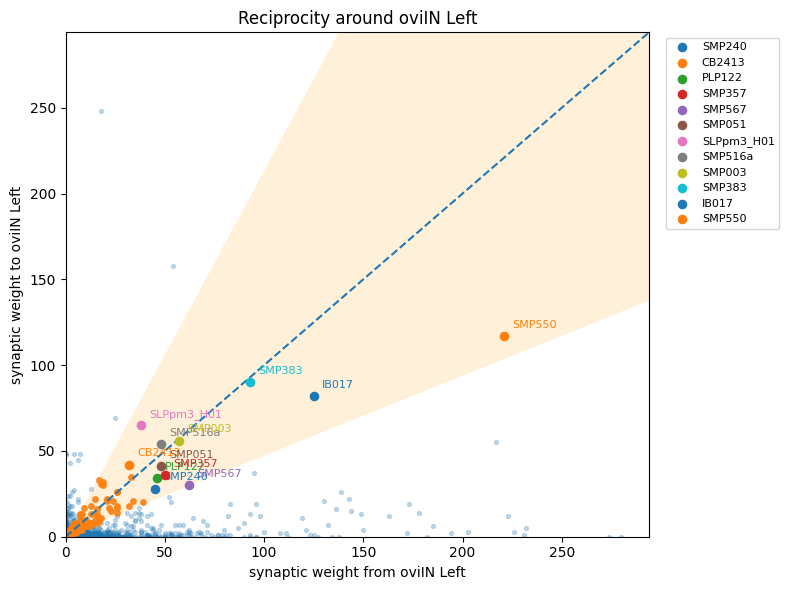

  → Analyzing oviIN Right (720575940625741287)
Figure saved to: figures/reciprocity_oviIN_Right_720575940625741287.png


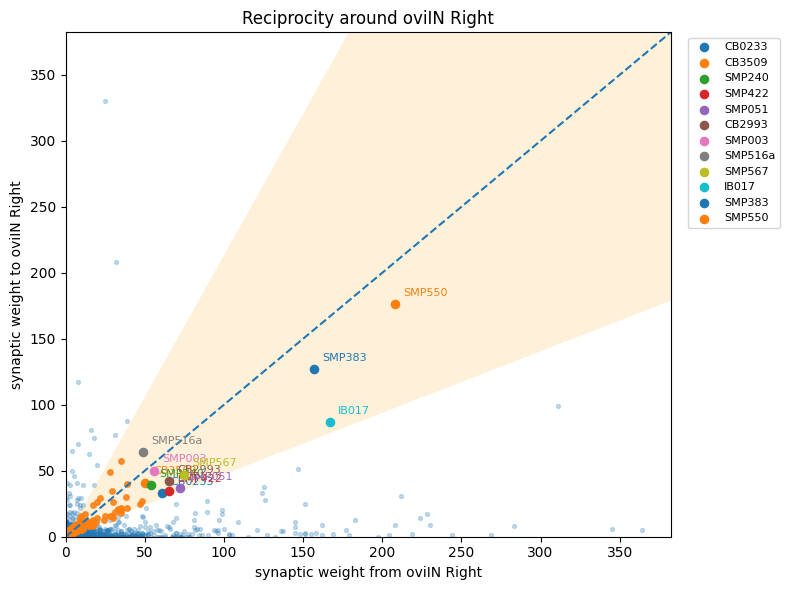


=== Processing group: PAL02 ===
  → Analyzing PAL02 Left (720575940628717585)
Figure saved to: figures/reciprocity_PAL02_Left_720575940628717585.png


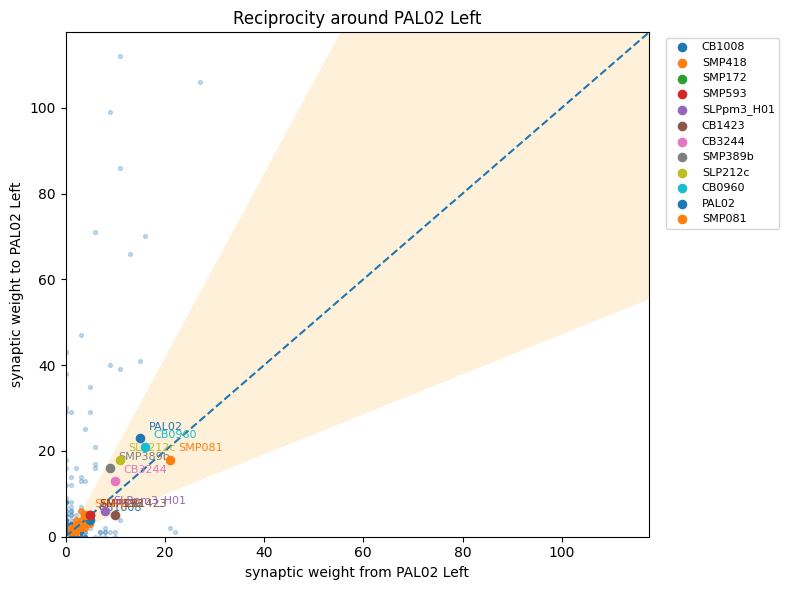

  → Analyzing PAL02 Right (720575940620716897)
Figure saved to: figures/reciprocity_PAL02_Right_720575940620716897.png


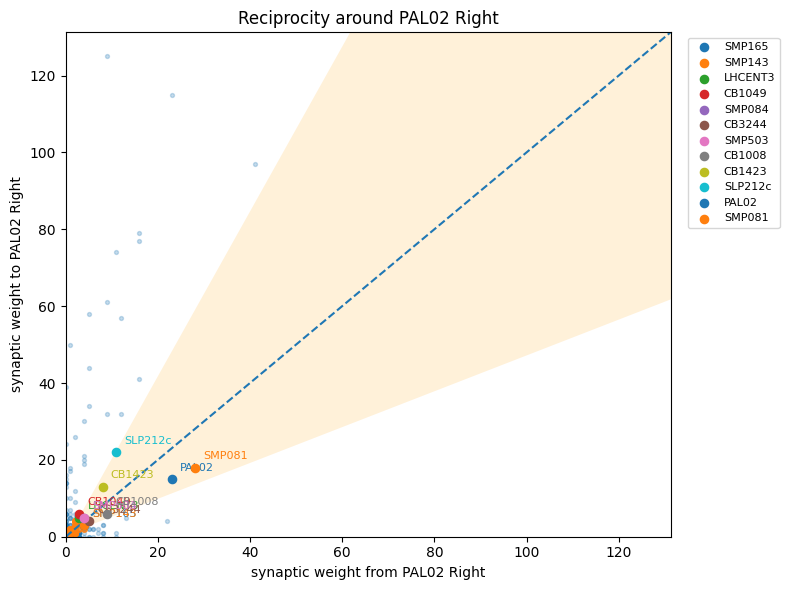


=== Processing group: PAL04 ===
  → Analyzing PAL04 Left (720575940632369439)
Figure saved to: figures/reciprocity_PAL04_Left_720575940632369439.png


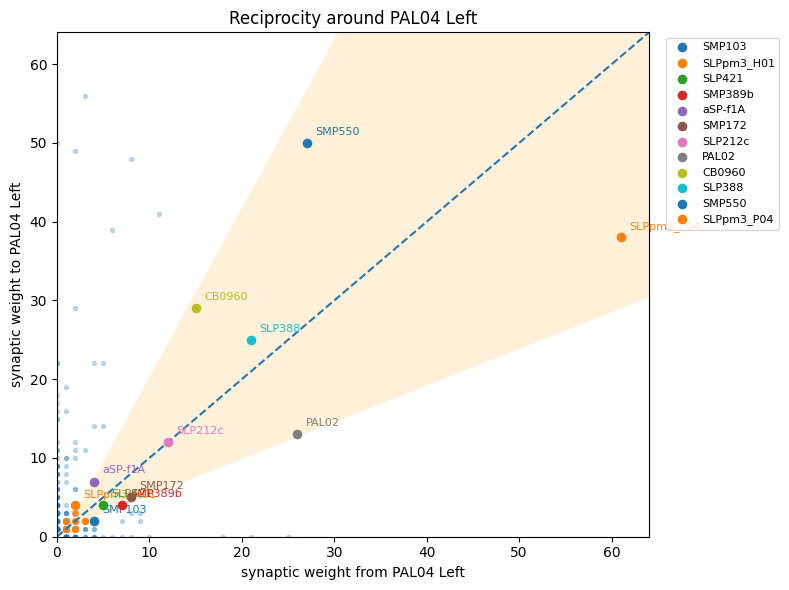

  → Analyzing PAL04 Right (720575940636990064)
Figure saved to: figures/reciprocity_PAL04_Right_720575940636990064.png


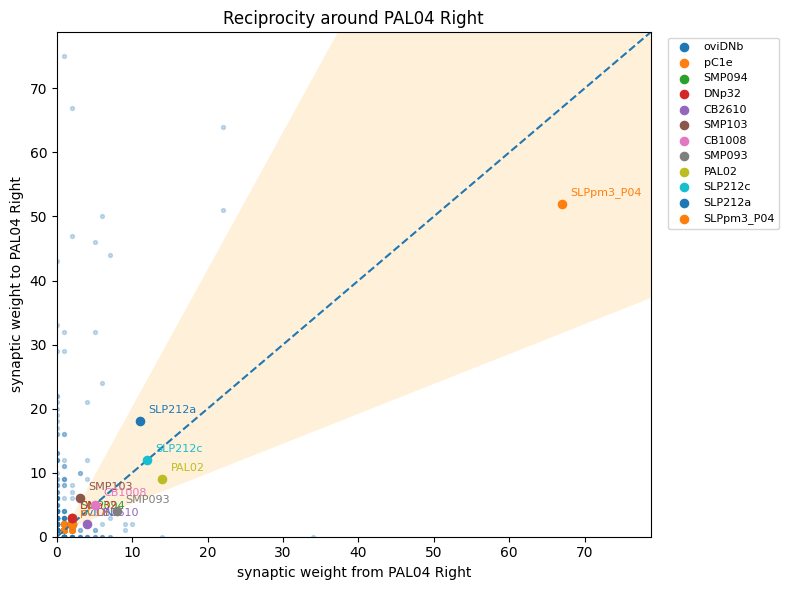


=== Processing group: Earmuff ===
  → Analyzing Earmuff Left 1 (720575940635642725)
Figure saved to: figures/reciprocity_Earmuff_Left_1_720575940635642725.png


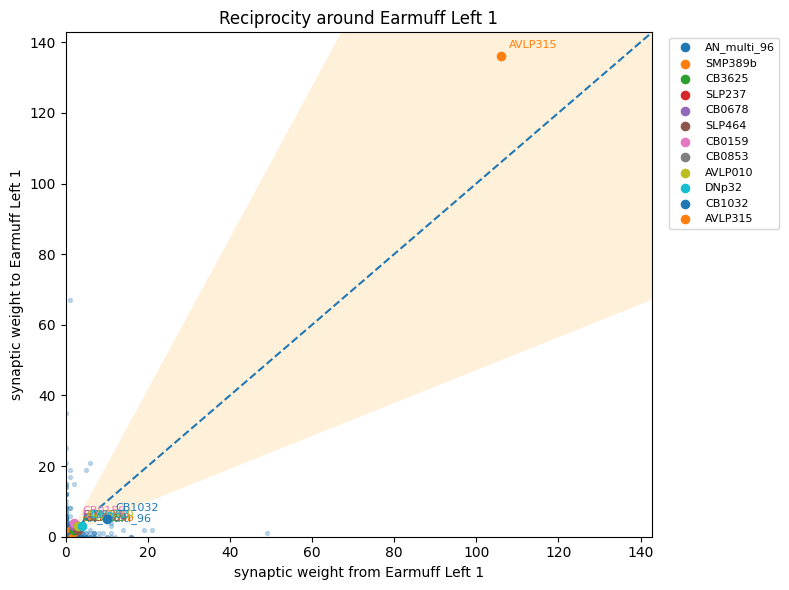

  → Analyzing Earmuff Right 1 (720575940611411057)
Figure saved to: figures/reciprocity_Earmuff_Right_1_720575940611411057.png


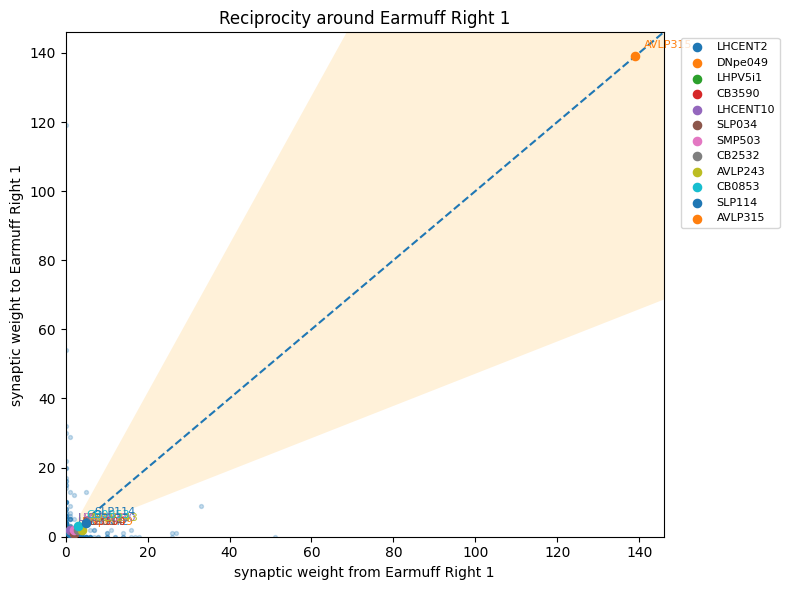

  → Analyzing Earmuff Left 2 (720575940629861163)
Figure saved to: figures/reciprocity_Earmuff_Left_2_720575940629861163.png


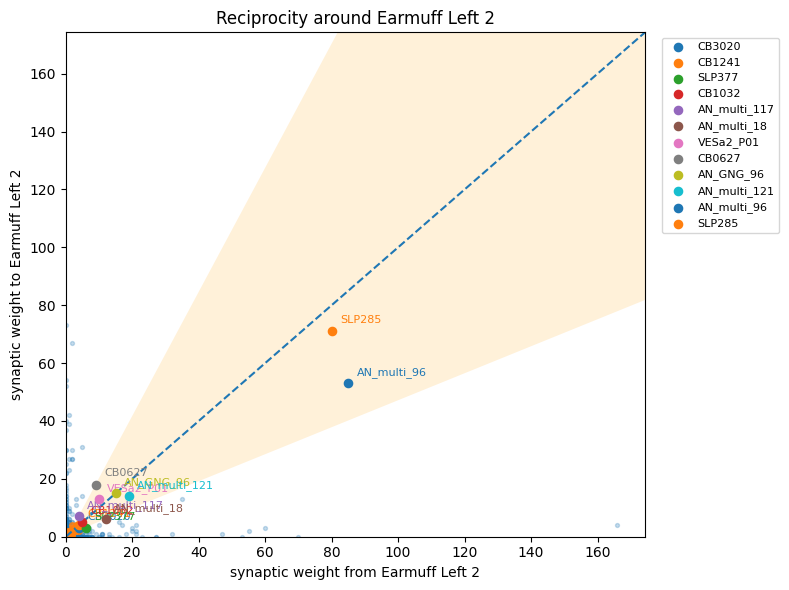

  → Analyzing Earmuff Right 2 (720575940629013199)
Figure saved to: figures/reciprocity_Earmuff_Right_2_720575940629013199.png


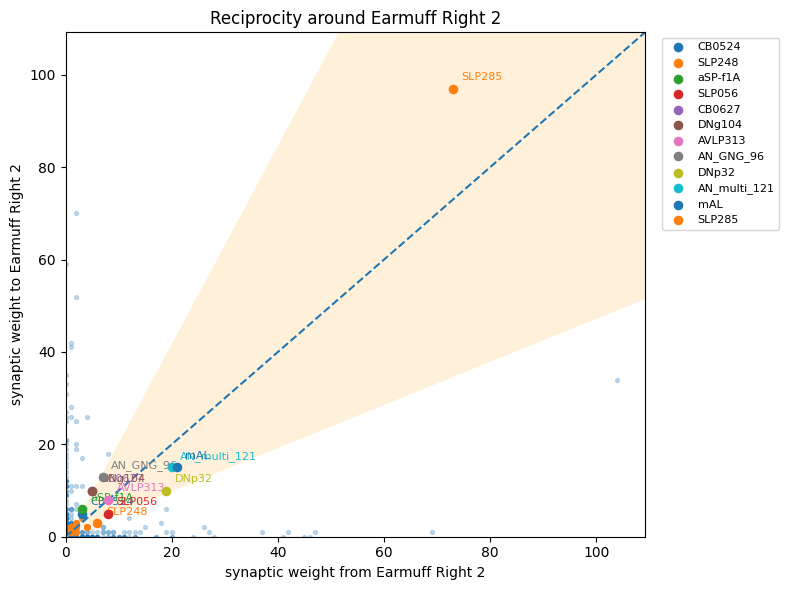


=== Processing group: Tophat ===
  → Analyzing Tophat Left 1 (720575940660281217)
Figure saved to: figures/reciprocity_Tophat_Left_1_720575940660281217.png


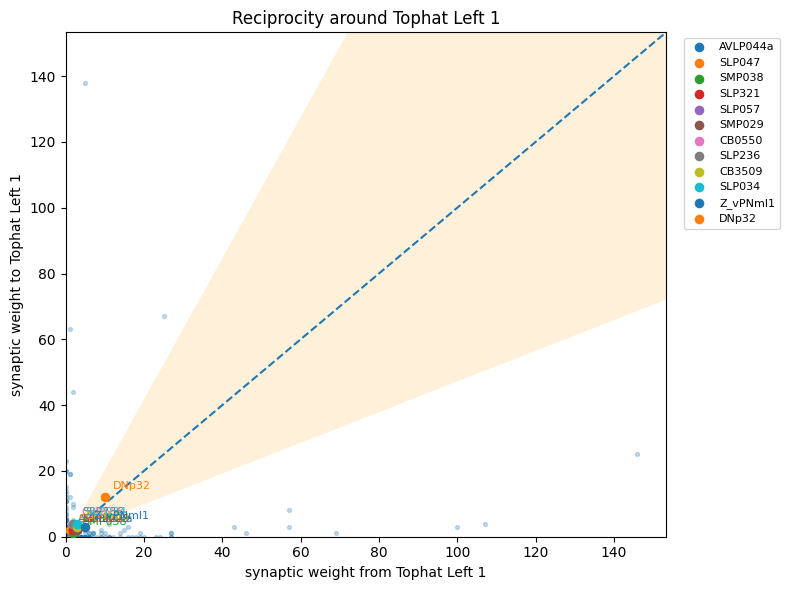

  → Analyzing Tophat Right 1 (720575940638865011)
Figure saved to: figures/reciprocity_Tophat_Right_1_720575940638865011.png


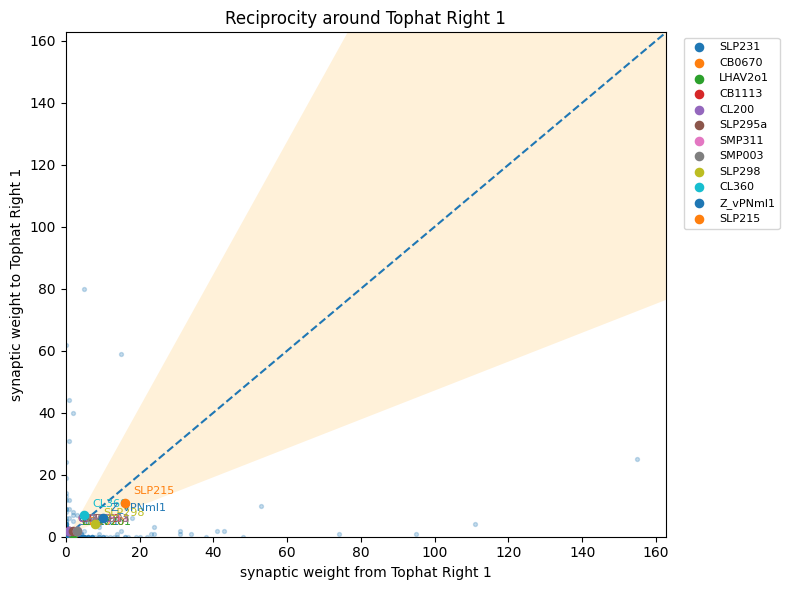

  → Analyzing Tophat Left 2 (720575940622541005)
Figure saved to: figures/reciprocity_Tophat_Left_2_720575940622541005.png


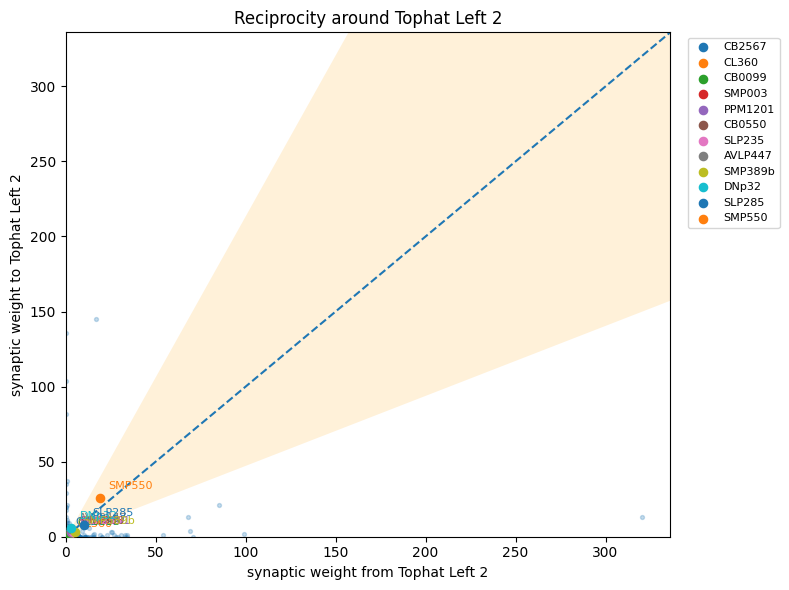

  → Analyzing Tophat Right 2 (720575940620441024)
Figure saved to: figures/reciprocity_Tophat_Right_2_720575940620441024.png


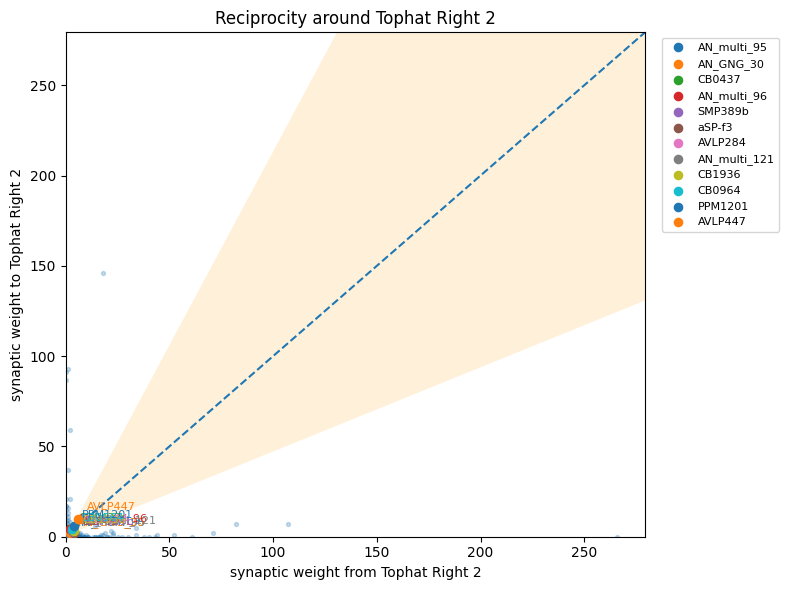


=== Processing group: SMP ===
  → Analyzing SMP544 (720575940633705636)
Figure saved to: figures/reciprocity_SMP544_720575940633705636.png


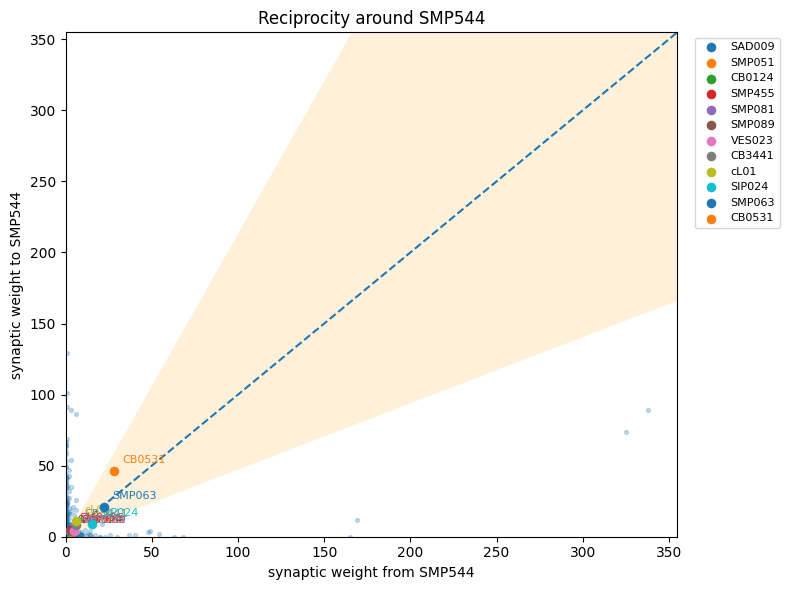


=== Summary of Top Reciprocal Partners ===


,Target neuron,Target ID,Top reciprocal cell type,Input weight (to target),Output weight (from target),Reciprocity score
0,oviEN Left,720575940612490958,oviIN,189,121,151.22
1,oviEN Right,720575940635515744,oviIN,240,172,203.17
2,oviIN Left,720575940628360506,SMP550,117,221,160.80
3,oviIN Right,720575940625741287,SMP550,176,208,191.33
4,PAL02 Left,720575940628717585,SMP550,106,27,53.50
5,PAL02 Right,720575940620716897,SMP550,97,41,63.06
6,PAL04 Left,720575940632369439,SLPpm3_P04,38,61,48.15
7,PAL04 Right,720575940636990064,SLPpm3_P04,52,67,59.03
8,Earmuff Left 1,720575940635642725,AVLP315,136,106,120.07
9,Earmuff Right 1,720575940611411057,AVLP315,139,139,139.00


In [8]:
# --- Run reciprocity analysis for all neurons of interest ---

results_summary = []  # collect summaries for display at the end

for group_name, neuron_dict in neurons_of_interest.items():
    print(f"\n=== Processing group: {group_name} ===")
    for target_id, target_label in neuron_dict.items():
        print(f"  → Analyzing {target_label} ({target_id})")

        # Compute bidirectional partner weights
        df_pairs = partner_weights_bidirectional(connections, target_id)
        df_pairs = attach_partner_types(df_pairs, cell_types)

        # Collapse reciprocity data by cell type instead of individual neuron
        df_pairs = (
            df_pairs.groupby("partner_type", as_index=False)[["in_w", "out_w"]]
            .sum()
            .sort_values("out_w", ascending=False, ignore_index=True)
        )

        # Compute reciprocity measure (geometric mean of in/out)
        df_pairs["reciprocity_score"] = np.sqrt(df_pairs["in_w"] * df_pairs["out_w"])

        # Identify most reciprocal partner cell type
        top_partner = df_pairs.loc[df_pairs["reciprocity_score"].idxmax()]

        results_summary.append({
            "Target neuron": target_label,
            "Target ID": target_id,
            "Top reciprocal cell type": top_partner["partner_type"],
            "Input weight (to target)": int(top_partner["in_w"]),
            "Output weight (from target)": int(top_partner["out_w"]),
            "Reciprocity score": round(top_partner["reciprocity_score"], 2)
        })

        # Generate and save reciprocity plot
        plot_reciprocity(
            df_pairs,
            target_label=target_label,
            target_id=target_id,
            wmin=1,
            angle_deg=20,
            annotate_top=12
        )

# --- Display summary for all analyzed neurons ---
summary_df = pd.DataFrame(results_summary)
print("\n=== Summary of Top Reciprocal Partners ===")
display(summary_df)
